In [2]:
pip install torch

   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/109.3 MB 2.0 MB/s eta 0:00:56
   ---------------------------------------- 0.2/109.3 MB 2.9 MB/s eta 0:00:38
   ---------------------------------------- 0.4/109.3 MB 3.1 MB/s eta 0:00:35
   ---------------------------------------- 0.5/109.3 MB 2.9 MB/s eta 0:00:38
   ---------------------------------------- 0.6/109.3 MB 2.7 MB/s eta 0:00:41
   ---------------------------------------- 0.7/109.3 MB 2.7 MB/s eta 0:00:41
   ---------------------------------------- 0.8/109.3 MB 2.6 MB/s eta 0:00:43
   ---------------------------------------- 0.9/109.3 MB 2.6 MB/s eta 0:00:42
   ---------------------------------------- 1.1/109.3 MB 2.6 MB/s eta 0:00:43
   ---------------------------------------- 1.1/109.3 MB 2.5 MB/s eta 0:00:44
   ---------------------------------------- 1.2/109.3 MB 2.5 MB/s eta 0:00:44
   ---------------------------------------- 1.3/109.3 MB 2.4 MB/s eta 0

ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'c:\\Python312\\share'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [22]:
player_stats = pd.read_csv('strict_player_stats.csv')
fifa_data = pd.read_csv('strict_fifa_data.csv')
validation_df = pd.read_csv('strict_validation.csv')

merged_data = pd.merge(
    player_stats, 
    validation_df[['Stats_Player', 'FIFA_Overall']], 
    left_on='Player', 
    right_on='Stats_Player',
    how='inner'
)

In [23]:
def prepare_features_for_training(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['Rk', 'Born', 'MP', 'Starts', 'Min', '90s', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in exclude_cols and df[col].nunique() > 1]
    
    features_df = df[feature_cols].copy()
    features_df = features_df.fillna(features_df.median())
    
    for col in features_df.columns:
        Q1 = features_df[col].quantile(0.25)
        Q3 = features_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        features_df[col] = np.clip(features_df[col], lower_bound, upper_bound)
    
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    return X_scaled, scaler, features_df.columns.tolist(), features_df

X_scaled, feature_scaler, feature_names, features_df = prepare_features_for_training(merged_data)
y_target = merged_data['FIFA_Overall']

print(f"🎯 Features: {len(feature_names)}")
print(f"🔢 Target Range: {y_target.min()} - {y_target.max()}")

🎯 Features: 132
🔢 Target Range: 47 - 91


In [24]:
def find_optimal_clusters(X, max_k=10):
    inertias = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

inertias = find_optimal_clusters(X_scaled)
optimal_k = 6  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
merged_data['Cluster'] = cluster_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged_data['PC1'] = X_pca[:, 0]
merged_data['PC2'] = X_pca[:, 1]

print(f"Clustering abgeschlossen: {optimal_k} Cluster")

Clustering abgeschlossen: 6 Cluster


In [25]:
class PlayerRatingPredictor(nn.Module):
    def __init__(self, input_size):
        super(PlayerRatingPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(32, 1),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        output = self.network(x)
        return output * 100  

def train_pytorch_model(X, y):
    y_scaled = y / 100.0
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y_scaled.values).view(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
    
    model = PlayerRatingPredictor(X.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=100
    )
    
    losses = []
    best_test_loss = float('inf')
    patience = 300
    patience_counter = 0
    
    print("🧠 Training PyTorch Model...")
    for epoch in range(2000):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train) / 100  
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test) / 100
            test_loss = criterion(test_outputs, y_test)
        
        scheduler.step(test_loss)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'  Early stopping at epoch {epoch}')
            model.load_state_dict(best_model_state)
            break
        
        if epoch % 200 == 0:
            print(f'  Epoch {epoch}: Train Loss = {loss.item():.4f}, Test Loss = {test_loss.item():.4f}')
    
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)
        
        train_r2 = r2_score(y_train.numpy().flatten() * 100, train_pred.numpy().flatten())
        test_r2 = r2_score(y_test.numpy().flatten() * 100, test_pred.numpy().flatten())
        train_mae = mean_absolute_error(y_train.numpy().flatten() * 100, train_pred.numpy().flatten())
        test_mae = mean_absolute_error(y_test.numpy().flatten() * 100, test_pred.numpy().flatten())
    
    print(f"\nPyTorch NN Results:")
    print(f"  Train R² = {train_r2:.3f}, Train MAE = {train_mae:.2f}")
    print(f"  Test R² = {test_r2:.3f}, Test MAE = {test_mae:.2f}")
    return model, losses

pytorch_model, losses = train_pytorch_model(X_scaled, y_target)

🧠 Training PyTorch Model...
  Epoch 0: Train Loss = 0.0803, Test Loss = 0.0624
  Epoch 200: Train Loss = 0.0012, Test Loss = 0.0003
  Epoch 400: Train Loss = 0.0009, Test Loss = 0.0003
  Epoch 600: Train Loss = 0.0007, Test Loss = 0.0003
  Epoch 800: Train Loss = 0.0006, Test Loss = 0.0003
  Epoch 1000: Train Loss = 0.0005, Test Loss = 0.0002
  Epoch 1200: Train Loss = 0.0005, Test Loss = 0.0002
  Early stopping at epoch 1400

PyTorch NN Results:
  Train R² = 0.996, Train MAE = 0.24
  Test R² = 0.924, Test MAE = 0.71


In [26]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_scaled, y_target)
rf_predictions = rf_model.predict(X_scaled)
rf_r2 = r2_score(y_target, rf_predictions)
rf_mae = mean_absolute_error(y_target, rf_predictions)

print(f"Random Forest: R² = {rf_r2:.3f}, MAE = {rf_mae:.2f}")

Random Forest: R² = 0.912, MAE = 0.93


In [27]:
def make_predictions(model, player_data, feature_names, scaler, model_type='pytorch'):
    X_new = player_data[feature_names].copy().fillna(player_data[feature_names].median())
    X_scaled = scaler.transform(X_new)
    
    if model_type == 'pytorch':
        model.eval()
        X_tensor = torch.FloatTensor(X_scaled)
        
        with torch.no_grad():
            predictions = model(X_tensor).numpy().flatten()
            predictions = np.clip(predictions, 0, 100)
    else:  
        predictions = model.predict(X_scaled)
        predictions = np.clip(predictions, 0, 100)
    
    return predictions

pytorch_predictions = make_predictions(pytorch_model, merged_data, feature_names, feature_scaler, 'pytorch')
rf_predictions = make_predictions(rf_model, merged_data, feature_names, feature_scaler, 'rf')

ensemble_predictions = 0.7 * pytorch_predictions + 0.3 * rf_predictions

results_df = merged_data[['Player', 'Nation', 'Pos', 'Squad', 'Age', 'FIFA_Overall', 'Cluster']].copy()
results_df['Predicted_Rating_PyTorch'] = pytorch_predictions
results_df['Predicted_Rating_RF'] = rf_predictions
results_df['Predicted_Rating_Ensemble'] = ensemble_predictions
results_df['Difference_PyTorch'] = results_df['Predicted_Rating_PyTorch'] - results_df['FIFA_Overall']
results_df['Difference_RF'] = results_df['Predicted_Rating_RF'] - results_df['FIFA_Overall']
results_df['Difference_Ensemble'] = results_df['Predicted_Rating_Ensemble'] - results_df['FIFA_Overall']

ensemble_r2 = r2_score(results_df['FIFA_Overall'], results_df['Predicted_Rating_Ensemble'])
ensemble_mae = mean_absolute_error(results_df['FIFA_Overall'], results_df['Predicted_Rating_Ensemble'])
print(f"\nEnsemble Model: R² = {ensemble_r2:.3f}, MAE = {ensemble_mae:.2f}")


Ensemble Model: R² = 0.838, MAE = 1.07



🏆 TOP 20 SPIELER NACH VORHERSAGE (ENSEMBLE):
                      Player   Pos              Squad  FIFA_Overall  \
696             Lionel Messi  FWMF          Paris S-G            91   
787            Karim Benzema    FW        Real Madrid            91   
856         Thibaut Courtois    GK        Real Madrid            90   
448          Virgil van Dijk    DF          Liverpool            90   
198             Manuel Neuer    GK      Bayern Munich            90   
685                  Ederson    GK    Manchester City            89   
300                 Casemiro    MF        Real Madrid            89   
251                Jan Oblak    GK  Atlï¿½tico Madrid            89   
888                  Alisson    GK          Liverpool            89   
850  Marc-Andrï¿½ ter Stegen    GK          Barcelona            88   
791           Erling Haaland    FW           Dortmund            88   
658               Harry Kane    FW          Tottenham            89   
269             Keylor Navas   

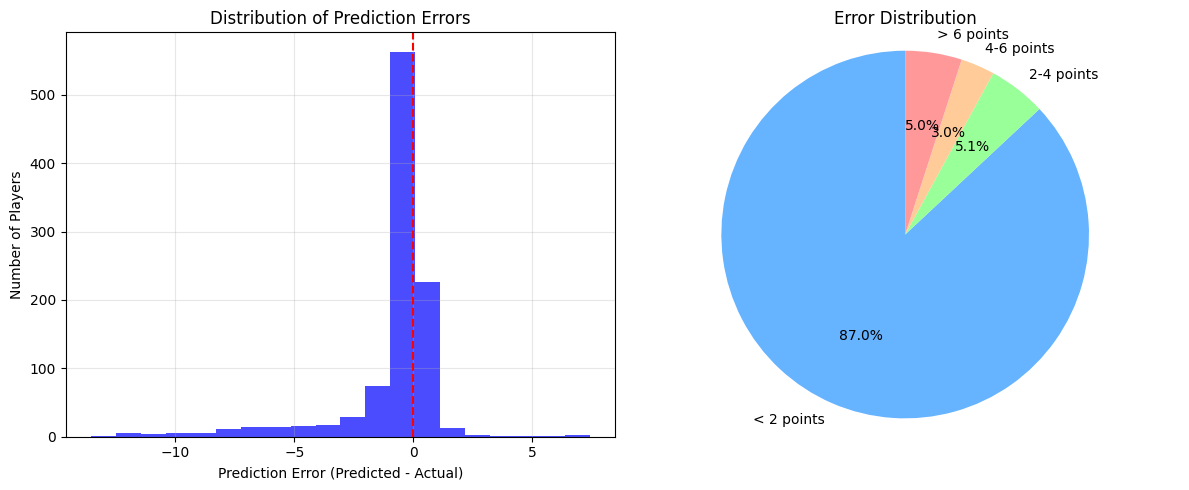


Prediction Errors by Position:


,mean,median,std,count
Pos,,,,
DF,-0.34,-0.06,1.73,340
MF,-1.04,-0.22,2.57,206
FW,-0.52,-0.30,1.18,126
FWMF,-1.70,-0.42,2.94,119
MFFW,-1.42,-0.34,2.39,80
GK,-0.56,-0.49,0.68,64
DFMF,-0.60,-0.12,1.38,27
MFDF,-0.47,-0.23,0.83,18
DFFW,-0.86,0.05,3.17,15


In [28]:
print(f"\n🏆 TOP 20 SPIELER NACH VORHERSAGE (ENSEMBLE):")
top_players = results_df.nlargest(20, 'Predicted_Rating_Ensemble')[
    ['Player', 'Pos', 'Squad', 'FIFA_Overall', 'Predicted_Rating_Ensemble', 'Difference_Ensemble']
]
print(top_players.round(1))

print(f"\n🔍 INTERESSANTE FÄLLE (Große Unterschiede):")
underrated = results_df.nlargest(10, 'Difference_Ensemble')[
    ['Player', 'Pos', 'Squad', 'FIFA_Overall', 'Predicted_Rating_Ensemble', 'Difference_Ensemble']
]
print("Underrated (Model > FIFA):")
print(underrated.round(1))
 
overrated = results_df.nsmallest(10, 'Difference_Ensemble')[
    ['Player', 'Pos', 'Squad', 'FIFA_Overall', 'Predicted_Rating_Ensemble', 'Difference_Ensemble']
]
print("\nOverrated (FIFA > Model):")
print(overrated.round(1))

print(f"\n📊 GENAUIGKEITSSTATISTIKEN:")
print(f"  Mittlere absolute Abweichung: {results_df['Difference_Ensemble'].abs().mean():.2f} Punkte")
print(f"  Median absolute Abweichung: {results_df['Difference_Ensemble'].abs().median():.2f} Punkte")
print(f"  Max Abweichung: {results_df['Difference_Ensemble'].abs().max():.2f} Punkte")
print(f"  Std.-Abweichung: {results_df['Difference_Ensemble'].abs().std():.2f} Punkte")

abs_diff = results_df['Difference_Ensemble'].abs()
print(f"\n  < 2 Punkte: {(abs_diff < 2).sum()} ({(abs_diff < 2).sum()/len(results_df)*100:.1f}%)")
print(f"  2-4 Punkte: {((abs_diff >= 2) & (abs_diff < 4)).sum()} ({((abs_diff >= 2) & (abs_diff < 4)).sum()/len(results_df)*100:.1f}%)")
print(f"  4-6 Punkte: {((abs_diff >= 4) & (abs_diff < 6)).sum()} ({((abs_diff >= 4) & (abs_diff < 6)).sum()/len(results_df)*100:.1f}%)")
print(f"  > 6 Punkte: {(abs_diff >= 6).sum()} ({(abs_diff >= 6).sum()/len(results_df)*100:.1f}%)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results_df['Difference_Ensemble'], bins=20, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Number of Players')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
labels = ['< 2 points', '2-4 points', '4-6 points', '> 6 points']
sizes = [
    (abs_diff < 2).sum(),
    ((abs_diff >= 2) & (abs_diff < 4)).sum(),
    ((abs_diff >= 4) & (abs_diff < 6)).sum(),
    (abs_diff >= 6).sum()
]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

position_errors = results_df.groupby('Pos')['Difference_Ensemble'].agg(['mean', 'median', 'std', 'count']).round(2)
position_errors = position_errors.sort_values('count', ascending=False)
print("\nPrediction Errors by Position:")
display(position_errors)

In [29]:
results_df[
    ['Player', 'Pos', 'Squad', 'FIFA_Overall', 'Predicted_Rating_Ensemble', 'Difference_Ensemble']
]

,Player,Pos,Squad,FIFA_Overall,Predicted_Rating_Ensemble,Difference_Ensemble
0,Osman Bukari,FWMF,Nantes,69,69.340905,0.340905
1,Fredrik Jensen,MFFW,Augsburg,70,68.607440,-1.392560
2,Mathias Jensen,MF,Brentford,64,63.149079,-0.850921
3,Enis Bardhi,MFFW,Levante,76,71.441839,-4.558161
4,Jordan Ferri,MF,Montpellier,77,77.255643,0.255643
...,...,...,...,...,...,...
1000,Fabien Centonze,DF,Metz,75,75.374211,0.374211
1001,Brandon Domingues,MFFW,Troyes,66,66.297592,0.297592
1002,Pietro Terracciano,GK,Fiorentina,76,75.615225,-0.384775
1003,Ludwig Augustinsson,DF,Sevilla,77,69.568825,-7.431175


In [30]:
print(f"\nDETAILLIERTE CLUSTER-ANALYSE:")
cluster_details = results_df.groupby('Cluster').agg({
    'Player': 'count',
    'FIFA_Overall': ['min', 'max', 'mean'],
    'Predicted_Rating_Ensemble': ['min', 'max', 'mean'],
    'Age': 'mean',
    'Pos': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed'
}).round(1)

cluster_details.columns = ['Anzahl', 'FIFA_Min', 'FIFA_Max', 'FIFA_Mean', 
                          'Pred_Min', 'Pred_Max', 'Pred_Mean', 'Age_Mean', 'Haupt_Position']
print(cluster_details)

print(f"\n👥 BEISPIEL-SPIELER PRO CLUSTER:")
for cluster in sorted(results_df['Cluster'].unique()):
    cluster_players = results_df[results_df['Cluster'] == cluster]
    top_player = cluster_players.nlargest(1, 'Predicted_Rating_Ensemble').iloc[0]
    avg_player = cluster_players.nlargest(5, 'Predicted_Rating_Ensemble').iloc[2]  
    
    print(f"\nCluster {cluster}:")
    print(f"  Top:    {top_player['Player']} ({top_player['Pos']}) - {top_player['Predicted_Rating_Ensemble']:.1f}")
    print(f"  Avg:    {avg_player['Player']} ({avg_player['Pos']}) - {avg_player['Predicted_Rating_Ensemble']:.1f}")
    print(f"  Größe:  {len(cluster_players)} Spieler")


DETAILLIERTE CLUSTER-ANALYSE:
         Anzahl  FIFA_Min  FIFA_Max  FIFA_Mean  Pred_Min  Pred_Max  Pred_Mean  \
Cluster                                                                         
0           173        50        89       74.1      53.4      87.2       73.7   
1           183        47        90       75.1      52.6      88.3       75.0   
2            65        65        90       78.4      66.3      88.5       77.9   
3           242        52        84       72.7      55.8      82.8       72.4   
4           178        62        89       77.4      63.5      87.7       76.4   
5           164        55        91       77.6      59.4      90.2       75.0   

         Age_Mean Haupt_Position  
Cluster                           
0            25.7             FW  
1            26.9             DF  
2            29.0             GK  
3            25.3             MF  
4            26.8             DF  
5            26.2           FWMF  

👥 BEISPIEL-SPIELER PRO CLUSTER:

Cluste